## project antenna pattern on the ellipsoid

In [42]:
include("../modules/antenna.jl")
include("../modules/geometry.jl")
include("../modules/scene.jl")
using ReferenceFrameRotations
using LinearAlgebra
using Plots

# read in vpol grid
vgrid = Antenna.AntGrid("../inputs/darts_ant_03192021.nc");



  0.582450 seconds (2.25 M allocations: 85.770 MiB)
  0.182464 seconds (2.89 M allocations: 107.794 MiB)


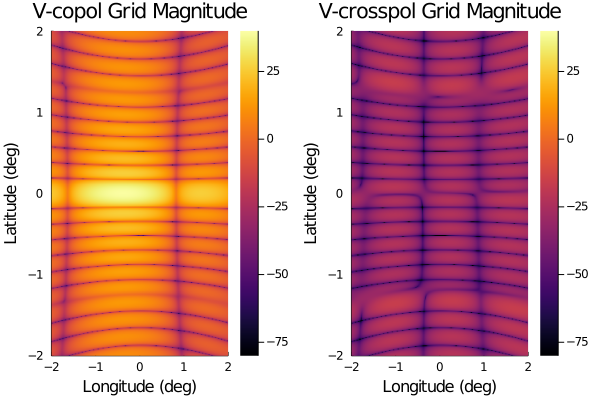

In [45]:
#platform position and velocity
P_pos = Geometry.geo_to_xyz([0, 0, 500e3]); #platform position in ECEF
P_vel = [0, 0, 6e3]; #platform velocity


# target volume grid on surface defined in geodetic lat, lon, height (θϕh)
t_θ=-2:.01:2 # deg
t_ϕ=-2:.005:2 # deg
t_h=0 # m target heights

#try the two different methods for creating this
@time t_geo_grid=Scene.form3Dgrid_for(t_θ,t_ϕ,t_h) # using 3 nested for loops 

#convert lat,lon,height grid to ECEF-xyz
t_xyz_grid=Geometry.geo_to_xyz(t_geo_grid) # convert target volume from geo to xyz


#get TCN frame to construct SC frame with
t,c,n = Geometry.get_tcn(P_pos, P_vel)

#create rotation quaternion from ECEF to tcn
q_ecef_tcn = dcm_to_quat(DCM([t';c';n']))
#create rotation quaternion from TCN to Ant frame
q_tcn_ant = Geometry.quat(-90, n) #rotate to match long side with t-vector
q_ant_look = Geometry.quat(5, [0,0,1])
q_ecef_ant = q_ant_look * q_tcn_ant * q_ecef_tcn


#create look vector
lvec = t_xyz_grid .- P_pos;
lhat = lvec./norm.(eachcol(lvec))';

#project look vector onto the antenna frame
lhat_ant = zeros(3,size(lhat,2))
@time for ii=1:size(lhat,2)
    lhat_ant[:,ii] = Geometry.rotate_frame(lhat[:,ii], q_ecef_ant);
end

#interpolate antenna pattern
cp,xp = Antenna.interpolate_pattern(vgrid, lhat_ant);
cp = reshape(cp, length(t_ϕ), length(t_θ));
xp = reshape(xp, length(t_ϕ), length(t_θ));



# plot Magnitude
p1 = heatmap(t_ϕ,t_θ, 20*log10.(abs.(cp')), 
    label = "", legend = :bottomleft, xlabel = "Longitude (deg)", ylabel = "Latitude (deg)",
    title = "V-copol Grid Magnitude", clim=(-80,40), fill=true)
p2 = heatmap(t_ϕ,t_θ, 20*log10.(abs.(xp')), 
    label = "", legend = :bottomleft, xlabel = "Longitude (deg)", ylabel = "Latitude (deg)",
    title = "V-crosspol Grid Magnitude", clim=(-80,40), fill=true)

plot(p1, p2, layout = (1,2))
